In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# import inspect

import torch
import torch.distributions as dist
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple

SEED=3012024

# Needed for downloading pretrained models from out Github repo
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [ ]:
torch.manual_seed(SEED)


## using the provided resource as base architecture
class VAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=DEVICE):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], 2*data_dim) # alpha and beta for every pixel
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        output = F.softplus(self.out_layer(h4)) # <------- We changed this to sigmoid to get our results...
        alpha = output[:, :self.data_dim]
        beta = output[:, self.data_dim:]
        return alpha, beta

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
def train(model: VAE, epoch: int, train_loader: torch.utils.data.DataLoader, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss_val, log_p, kld = loss(recon_batch, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"log prob={log_p} KLD={kld}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [ ]:
def test(model: VAE, epoch: int, test_loader: torch.utils.data.DataLoader) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            recon_batch, mu, logvar = model(x)
            test_loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if DEVICE=="cuda" else {}

batch_size = 128

train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size, shuffle=False, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 112549299.52it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 95307390.89it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47621906.67it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4610486.15it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
def loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    x = x.view(-1, 784)
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    alpha, beta = recon_x
    altered_x = torch.clamp(x, 1e-4, 1-1e-4)
    normalization = torch.lgamma(alpha+beta) - torch.lgamma(alpha) - torch.lgamma(beta)
    log_p_all = -torch.sum((alpha - 1.0) * torch.log(altered_x) + (beta - 1.0) * torch.log(1.0 - altered_x) + normalization)
    #log_p = torch.mean(log_p_all)
    return log_p_all + KLD, log_p_all, KLD # = -ELBO

EPOCHS=10

model = VAE(hidden_dims=[300, 50, 2, 50, 300])
optimizer = optim.Adam(model.parameters(), lr=1e-3)

load_model = True
if load_model:
    !wget "https://github.com/Dani440b/PML-Exam/raw/main/models/BETA_VAE_200.model"
    model.load_state_dict(torch.load('./BETA_VAE_200.model'))
else:
    train_loss_vals_total = []
    test_loss_vals_total = []
    for e in range(1, EPOCHS+1):
        train_loss_vals = train(model, epoch=e, train_loader=train_loader)
        test_loss_vals = test(model, epoch=e, test_loader=test_loader)
        train_loss_vals_total.append(train_loss_vals)
        test_loss_vals_total.append(test_loss_vals)

--2024-01-18 13:15:57--  https://github.com/Dani440b/PML-Exam/raw/main/models/BETA_VAE_200.model
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-01-18 13:15:58 ERROR 404: Not Found.



FileNotFoundError: [Errno 2] No such file or directory: './BETA_VAE_200.model'

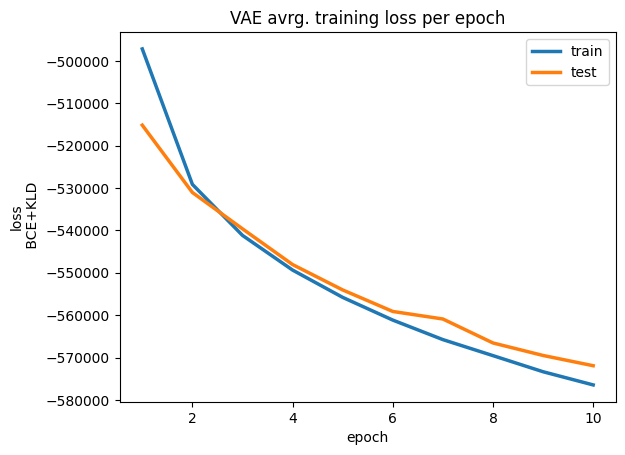

In [ ]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

In [ ]:
# encode entries
latent_coordinates = []
for data in train_data:
    # NOTE: we only obtain the mean for encoding and discard the log var
    latent_coordinates.append(model.encode(data[0].to(DEVICE).view(-1, 784))[0].cpu().detach().numpy())
latent_coordinates = np.array(latent_coordinates).reshape(60000, -1)

In [ ]:
latent_coordinates = latent_coordinates.reshape(60000, -1)
train_labels = [data[1] for data in train_data]

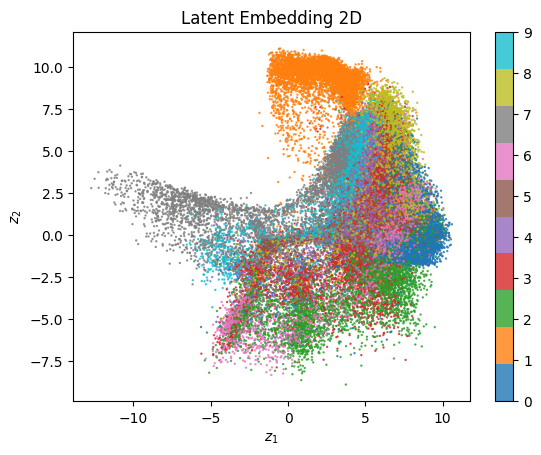

In [ ]:
# visualize 2D embedding of MNIST
plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=train_labels, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D")
plt.show()

### Visualization by Gauss CDF

In [ ]:
## 2.) visualize across Gaussian CDF
n_cols = 12
z_space = torch.linspace(0.0001, 0.9999, n_cols) # for 5x5 grid
std_gauss = torch.distributions.normal.Normal(0, 1)

xx, yy = torch.meshgrid(z_space, z_space)

zz_gauss_cdf_vals = torch.dstack([std_gauss.icdf(xx), std_gauss.icdf(yy)]).reshape(-1, 2)
zz_gauss_cdf_vals.shape

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([144, 2])

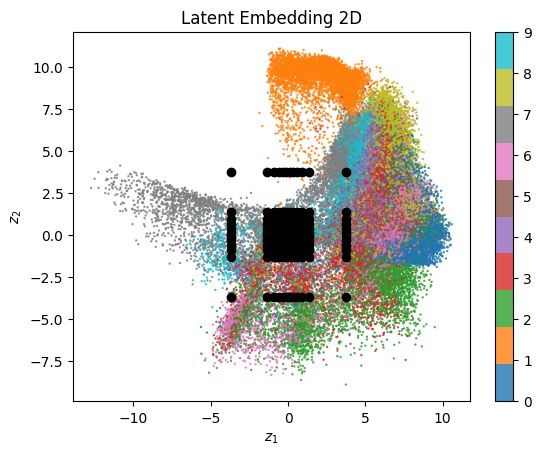

In [ ]:
plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=train_labels, cmap="tab10")
plt.colorbar()
plt.scatter(zz_gauss_cdf_vals[:,0], zz_gauss_cdf_vals[:,1], color='black')
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.title("Latent Embedding 2D")
plt.show()

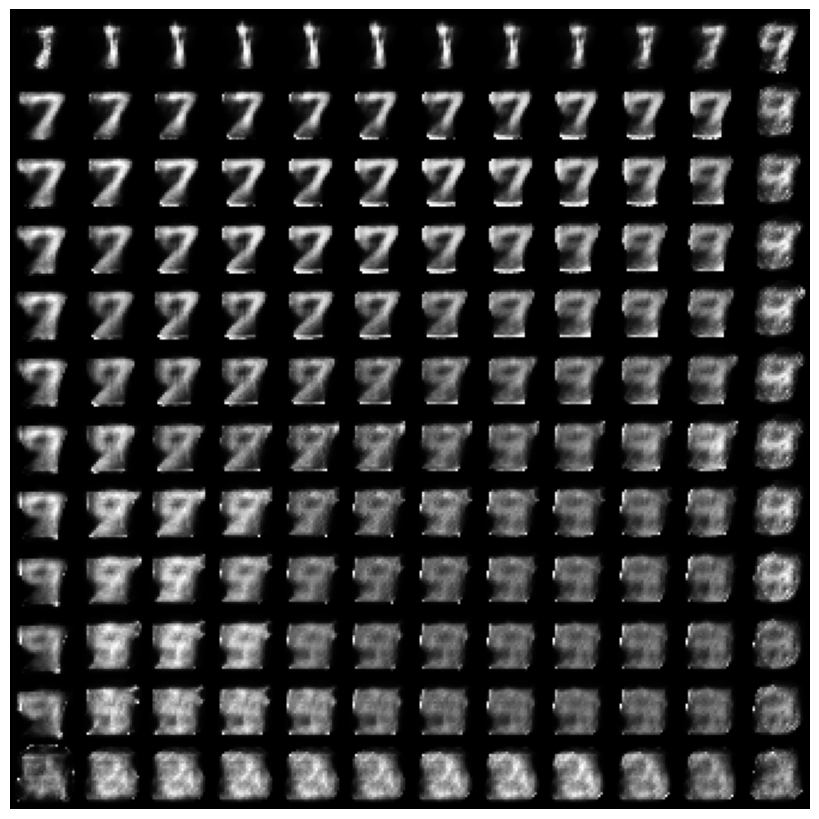

In [ ]:
fig, ax = plt.subplots(nrows=n_cols, ncols=n_cols, figsize=(8,8))

def mu_beta(alpha, beta):
    return alpha/(alpha+beta)

k = 0
for j in range(n_cols):
    for i in range(n_cols-1, -1, -1):
        _zz = zz_gauss_cdf_vals[k].view(1, -1)
        alpha, beta = model.decode(_zz.to(DEVICE))
        reconstruction = mu_beta(alpha.cpu().detach().numpy(), beta.cpu().detach().numpy())
        img = reconstruction.reshape((28,28))
        ax[i, j].imshow(img, cmap='gray')
        ax[i, j].set_axis_off()
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        k += 1
# plt.suptitle("MNIST reconstruction")
plt.tight_layout(w_pad=0., pad=0., h_pad=0.)
plt.show()

In [ ]:
clamp_threshold = 1e-4

def marginal_likelihood(data, model, N=128):
    log_p_xs = torch.zeros(len(data))
    for i, (image, _) in enumerate(data):
        mu, logvar = model.encode(image.to(DEVICE).view(-1, 784))
        mu = mu.cpu().detach()
        logvar = logvar.cpu().detach()
        var = torch.exp(logvar)
        q = dist.MultivariateNormal(mu, var * torch.eye(2))
        z = q.sample((N,))
        log_p_z = dist.MultivariateNormal(torch.zeros(2), torch.eye(2)).log_prob(z)
        log_q_z = q.log_prob(z)
        alpha, beta = model.decode(z.to(DEVICE)).cpu().detach()
        image = torch.clamp(image, 1e-4, 1-(1e-4))

        normalization = torch.lgamma(alpha+beta) - torch.lgamma(alpha) - torch.lgamma(beta)
        log_p_beta = -torch.sum((alpha - 1.0) * torch.log(image.view(-1, 784).repeat(N, 1, 1)) + (beta - 1.0) * torch.log(1.0 - image.view(-1, 784).repeat(N, 1, 1)) + normalization, axis=2)

        #log_p_cb = torch.sum((-1) * F.binary_cross_entropy(lam, image.view(-1, 784).repeat(N, 1, 1), reduction="none") + LogC(lam), axis=2)
        log_something = log_p_beta + log_p_z - log_q_z
        log_p_x = -np.log(N) + torch.logsumexp(log_something, dim=0)
        log_p_xs[i] = log_p_x[0]
    return log_p_xs.mean()

In [ ]:
# Det virker måske rigtigt nok. Den er ihvertfald omkring ELBO.
print('marginal likelihood: ', marginal_likelihood(test_data, model, N=128))